In [108]:
import numpy as np
import tensorflow as tf


# Percorsi ai file
X = np.load("dataset_75/images.npy")
y = np.load("dataset_75/labels.npy")

X = X.astype("float32") / 255.0

X = X[..., np.newaxis]

print(X.shape)  # es. (18000, 150, 150) o (18000, 75, 75)
print(y.shape)  # es. (18000, 2)



(18000, 75, 75, 1)
(18000, 2)


In [109]:
label_range=30 #minutes the are togheter in the same class
number_of_classifiers=12*60//label_range

hours_decimal=y[:,0]+y[:,1]/60
hours_normalized=hours_decimal/12
hours_angolized=hours_normalized*2*np.pi
labels=np.column_stack((np.cos(hours_angolized), np.sin(hours_angolized)))

print(labels[10999])
print(y[10999])
print(number_of_classifiers)

[-0.77162458 -0.63607822]
[ 7 19]
24


In [110]:
from sklearn.model_selection import train_test_split

X_traina, X_test, y_traina, y_test = train_test_split(X, labels, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True)

print(y_test.shape)
print(y_val.shape)
print(y_train.shape)
print(y_train[0].shape)

(1800, 2)
(1800, 2)
(14400, 2)
(2,)


In [111]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers, models, regularizers
from keras.optimizers import AdamW
from keras.callbacks import ReduceLROnPlateau


In [112]:
class CosSin(layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=-1)

model_base = models.Sequential([
    keras.layers.Conv2D(32, (5,5), padding="same", input_shape=X_train[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    #keras.layers.AveragePooling2D(2,2),
    keras.layers.Dropout(0.3),    

    keras.layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    #keras.layers.Dropout(0.3), 
    layers.Dense(64, activation="relu" ),
    
    layers.Dropout(0.3),
    keras.layers.Dense(2),
    CosSin()
])

In [113]:
def angular_mse(y_true, y_pred):
    # sicurezza: normalizza su cerchio
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    th_t = tf.atan2(y_true[...,1], y_true[...,0])  # atan2(sin, cos)
    th_p = tf.atan2(y_pred[...,1], y_pred[...,0])
    d   = tf.atan2(tf.sin(th_p - th_t), tf.cos(th_p - th_t))  # wrap in (−π, π]
    return tf.reduce_mean(tf.square(d)) 


def angular_mae_minutes(y_true, y_pred):
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    th_t = tf.atan2(y_true[...,1], y_true[...,0])
    th_p = tf.atan2(y_pred[...,1], y_pred[...,0])
    d   = tf.atan2(tf.sin(th_p - th_t), tf.cos(th_p - th_t))
    err_min = tf.abs(d) * (12.*60.) / (2.*np.pi)       # minuti su quadrante 12h
    return tf.reduce_mean(err_min)

model_base.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=5e-5),
    loss=angular_mse,
    metrics=[angular_mae_minutes]
)

In [114]:
# Reduce LR when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True
)

early_stopping=keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [115]:
history_base = model_base.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler,checkpoint,early_stopping]
)


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - angular_mae_minutes: 178.2703 - loss: 3.2323 - val_angular_mae_minutes: 179.2029 - val_loss: 3.2624 - learning_rate: 0.0010
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - angular_mae_minutes: 178.3132 - loss: 3.2619 - val_angular_mae_minutes: 177.1546 - val_loss: 3.2096 - learning_rate: 0.0010
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - angular_mae_minutes: 174.2678 - loss: 3.1256 - val_angular_mae_minutes: 178.9549 - val_loss: 3.2535 - learning_rate: 0.0010
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - angular_mae_minutes: 167.5469 - loss: 2.9415 - val_angular_mae_minutes: 180.5365 - val_loss: 3.3202 - learning_rate: 0.0010
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - angular_mae_minutes: 163.3818 - loss: 2.8280 - val_angular_mae_minutes: 180.1365 - val_loss: 3.3067 - learning_rate: 0.0010
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - angular_mae_minutes: 148.7152 - loss: 2.4359

In [117]:
best = keras.models.load_model(
    "best_model.keras",
    custom_objects={
        "CosSin": CosSin,
        "angular_mse": angular_mse,
        "angular_mae_minutes": angular_mae_minutes
    }
)

# Valutiamo sul test set
test_loss, test_acc = best.evaluate(X_train, y_train)
print(f"Loss sul train set: {test_loss:.4f}")
print(f"Accuratezza sul train set: {test_acc:.4f}")

# Valutiamo sul test set
test_loss, test_acc = best.evaluate(X_test, y_test)
print(f"Loss sul test set: {test_loss:.4f}")
print(f"Accuratezza sul test set: {test_acc:.4f}")

2025-10-26 10:33:27.781647: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-26 10:33:28.075160: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 100 bytes spill stores, 100 bytes spill loads



450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - angular_mae_minutes: 6.4712 - loss: 0.0057
Loss sul train set: 0.0057
Accuratezza sul train set: 6.4712
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - angular_mae_minutes: 8.0832 - loss: 0.0095 
Loss sul test set: 0.0095
Accuratezza sul test set: 8.0832


In [119]:
y_pred = model_base.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

"""from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()
"""



 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


'from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\ncm = confusion_matrix(y_test, y_pred_classes)\nConfusionMatrixDisplay(cm).plot()\n'

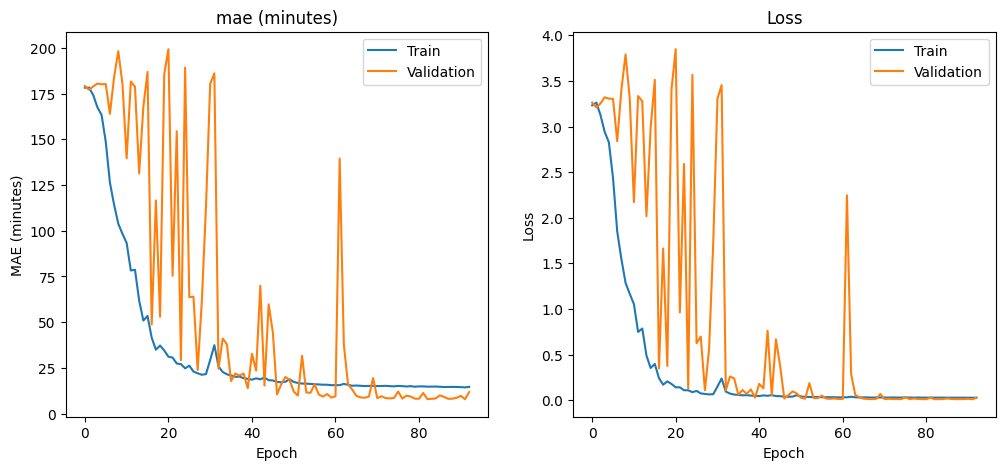

In [122]:
plt.figure(figsize=(12,5))

# Angular MAE (in minuti)
plt.subplot(1,2,1)
plt.plot(history_base.history["angular_mae_minutes"], label="Train")
plt.plot(history_base.history["val_angular_mae_minutes"], label="Validation")
plt.title("mae (minutes)")
plt.xlabel("Epoch")
plt.ylabel("MAE (minutes)")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_base.history["loss"], label="Train")
plt.plot(history_base.history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
